# Toy data wine classification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/5.binary-classifier-wine.ipynb)

By [Terence Parr](https://explained.ai).

Shifting to binary classification now, we consider the toy wine data set and build models that use features proline and alcohol to predict wine classification (class 0 or class 1). We will add a sigmoid activation function to the final linear layer, which will give us the probability that an input vector represents class 1. A single linear layer plus the sigmoid yields a standard logistic regression model. By adding another linear layer and nonlinearity, we see a curved decision boundary between classes. By adding lots of neurons and more layers, we see even more complex decision boundaries appear.

## Support code

In [25]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

In [26]:
def show(df, normalize=False, file=None):
    if normalize:
        df = df.copy()
        df.proline = (df.proline-np.mean(df.proline))/np.std(df.proline)
        df.alcohol = (df.alcohol-np.mean(df.alcohol))/np.std(df.alcohol)
        
    fig, ax = plt.subplots(figsize=(4,3))
    df0 = df[df['class']==0]
    df1 = df[df['class']==1]
    ax.scatter(df0.proline, df0.alcohol, marker='x', s=45, color='#F46C43', alpha=1, label='class 0')
    ax.scatter(df1.proline, df1.alcohol, marker='o', s=45, color='#4574B4', alpha=.7, label='class 1')
    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.set_xlabel("proline")
    ax.set_ylabel("alcohol")
    ax.set_title("Wine classification")
    plt.legend(loc='lower right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
    plt.show()

In [27]:
def dshow(X, y, model, boundary_tolerance=.03, file=None):
    grid = []
    for p in np.linspace(min(X[:,0]),max(X[:,0]),num=100):
        for a in np.linspace(min(X[:,1]),max(X[:,1]),num=100):
            grid.append([p,a])
    grid = torch.tensor(grid).float()
    decisions = model(grid).detach().numpy().reshape(-1)
    
    grid_boundary = grid[np.isclose(decisions,0.5,atol=boundary_tolerance),:]
    
    fig, ax = plt.subplots(figsize=(5,4))
    X0 = X[y==0]
    X1 = X[y==1]

    orange = colour.Color("#F46C43")
    blue = colour.Color("#4574B4")
    mycolors = np.array(list(c.hex for c in orange.range_to(blue, 100+1)))
    mycolors = mycolors[(decisions*100).astype(int)]
    cmap = plt.get_cmap('coolwarm')
    norm = colors.Normalize(np.min(decisions), np.max(decisions)) # cmap(norm(decisions))
    ax.scatter(grid[:,0], grid[:,1], s=.2, c=mycolors, alpha=.3)

    ax.scatter(grid_boundary[:,0], grid_boundary[:,1], s=1, c='k', alpha=1)

    ax.scatter(X0[:,0], X0[:,1], marker='x', s=45, lw=.9, color='#F46C43', alpha=1, label='class 0')
    ax.scatter(X1[:,0], X1[:,1], marker='o', s=45, lw=.9, color='#4574B4', alpha=.75, label='class 1')    

    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)

    ax.set_xlabel("proline")
    ax.set_ylabel("alcohol")
    ax.set_title("Wine classification")
    plt.legend(loc='lower right')
    plt.tight_layout()

    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
    
    plt.show()

## Load, normalize, and display 2D variable space

In [28]:
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['class'] = wine.target
df = df[df['class'].isin({0,1})] # convert from k=3 to k=2 classes
df.head(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0


In [29]:
df = df[['proline','alcohol','class']]
df.head(3)

,proline,alcohol,class
0,1065.0,14.23,0
1,1050.0,13.20,0
2,1185.0,13.16,0


Because there are only two features, we can easily represent the feature space with a 2D plot. The class of each feature vector is identified with an x or a dot. Here is what feature space looks like in the original coordinate system:

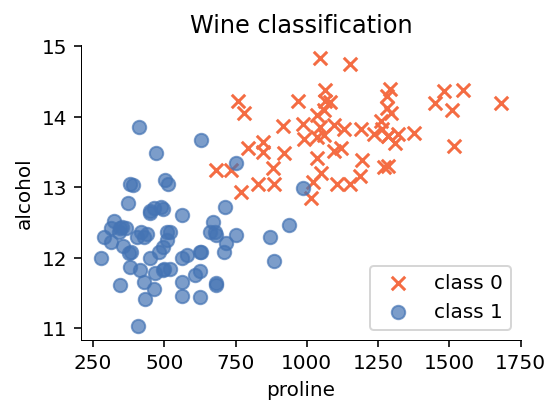

In [30]:
show(df, file="wine")

And here is what it looks like with normalized $x_i$ coordinates:

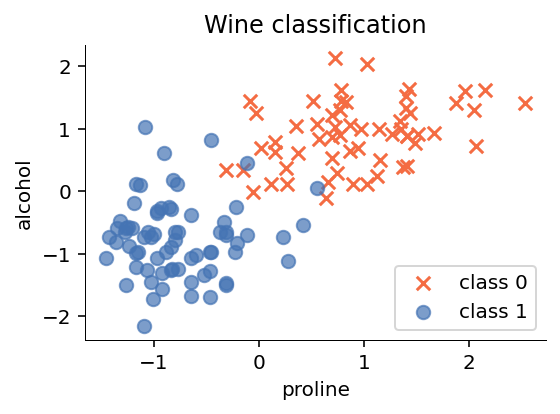

In [31]:
show(df, normalize=True, file="wine-norm")

Using the human eye, we can easily draw a line or more complex decision boundaries between the two classes, but let's figure out how to train a model to do that.

## Train and show logistic regression decision boundary

Logistic regression finds a separating hyper plane between vectors of different classes. Let's start out by normalizing our data and getting into into tensors:

In [37]:
X = df[['proline','alcohol']].values
y = df['class'].values
X = (X-np.mean(X,axis=0))/np.std(X,axis=0)
X_ = torch.tensor(X).float()
y_ = torch.tensor(y).reshape(-1,1).float()

### Classifier training mechanism

Training a classifier versus a regressor is mostly about using a different loss function. Regressors typically use mean squared error, but classifiers typically used log loss (cross entropy loss):

<img src="images/regr-class.png" width="700">

Of course, the classification model is slightly different as well because it has a sigmoid activation function on the last layer:

<table border="0">
    <tr>
        <th>Regression</th><th></th><th>Classification</th>
    </tr>
    <tr>
        <td><img src="images/linreg.png" width="160"></td>
        <td width="30%"></td>
        <td><img src="images/logistic.png" width="200"></td>
    </tr>
</table>

Here's a basic training method (but one that only tracks the training loss, not also the validation loss).

In [33]:
def ctrain(model, X, y, learning_rate = .0001, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X)
        loss = F.binary_cross_entropy(y_pred, y)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:5d} cross entropy loss {loss:7.4f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST        cross entropy loss {loss:7.4f}")
    return y_pred, loss

A standard logistic regression model does not have a hidden layer so it directly computes an output probability from the input features by running a linear regression output through a sigmoid:

In [34]:
model = nn.Sequential(
    nn.Linear(2, 1), # 2 input vars: proline, alcohol
    nn.Sigmoid(),    # yield p(y=1|x)
)

To train this model, let's call our classifier training function with a suitable learning rate (that I conjured up after playing around a bit).

In [35]:
y_pred, loss = ctrain(model, X=X_, y=y_, learning_rate = .001, nepochs=10_000)

Epoch     0 cross entropy loss  1.2633
Epoch  1000 cross entropy loss  0.4792
Epoch  2000 cross entropy loss  0.2562
Epoch  3000 cross entropy loss  0.1747
Epoch  4000 cross entropy loss  0.1349
Epoch  5000 cross entropy loss  0.1121
Epoch  6000 cross entropy loss  0.0980
Epoch  7000 cross entropy loss  0.0890
Epoch  8000 cross entropy loss  0.0832
Epoch  9000 cross entropy loss  0.0796
Epoch 10000 cross entropy loss  0.0775
LAST        cross entropy loss  0.0775


And here is how we compute the accuracy of the training set:

In [55]:
y_class = (model(X_)>0.5).numpy().astype(int) # p(y=1|x)
ncorr = sum(y_class == y_.numpy())
n = len(y)
print(f"Train accuracy {ncorr[0]*100/n:.2f}")

Train accuracy 96.15


#### Exercise

Split the wine data set into train/validation sets and then compute the validation loss / accuracy.

Using the handy display function from the support code above, we can show all of the entities in 2D feature space, their true classification, and the logistic regression separating hyper plane.  The dotted line separator is created by comparing the model predictions, $p(y=1|\bf x)$, for all grid locations in feature space to probability 0.5. Any $\bf x$ whose prediction is within a small tolerance of 0.5 is considered on the boundary and is plotted with a black dot.

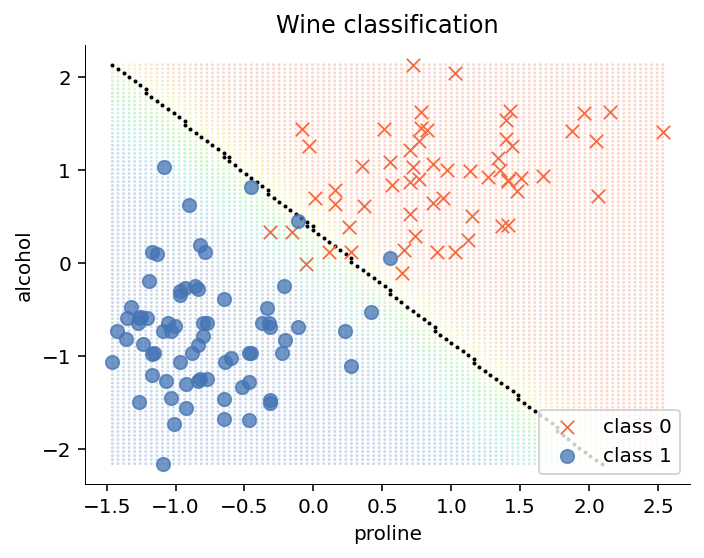

In [12]:
dshow(X, y, model, boundary_tolerance=.02, file="lin1S")

## Train a hidden layer with 3 neurons + output layer

Let's go beyond simple logistic regression and add a hidden layer with three neurons; for a nice curvy decision boundaries, we can use a sigmoid not a ReLU as the glue between the layers:

Epoch     0 cross entropy loss  0.8248
Epoch  1500 cross entropy loss  0.2674
Epoch  3000 cross entropy loss  0.1222
Epoch  4500 cross entropy loss  0.0936
Epoch  6000 cross entropy loss  0.0842
Epoch  7500 cross entropy loss  0.0778
Epoch  9000 cross entropy loss  0.0641
Epoch 10500 cross entropy loss  0.0552
Epoch 12000 cross entropy loss  0.0498
Epoch 13500 cross entropy loss  0.0454
Epoch 15000 cross entropy loss  0.0426
LAST        cross entropy loss  0.0426


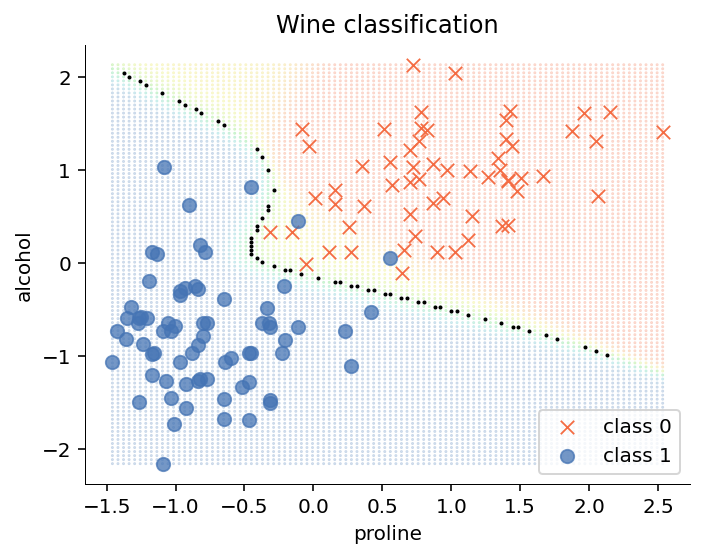

In [16]:
model = nn.Sequential(
    nn.Linear(2, 3), # two input features, proline and alcohol; 3 neurons in layer
    nn.Sigmoid(),    # could also be ReLU
    nn.Linear(3, 1),
    nn.Sigmoid()
)

y_pred, loss = ctrain(model, X=X_, y=y_, learning_rate = .001, nepochs=15_000)

dshow(X, y, model, file="lin3Slin1S")

#### Exercise

Why is the cross entropy loss lower for this model than the logistic regression model?

<details>
<summary>Solution</summary>

Because there are more parameters, this model has much more power than a logistic regression model and can draw surface that gives a slightly more accurate decision boundary.
</details>

## Train a hidden layer with 10 neurons + output layer

Let's see what happens when we use 10 instead of three neurons in our model.

Epoch     0 cross entropy loss  0.6966
Epoch  1500 cross entropy loss  0.0953
Epoch  3000 cross entropy loss  0.0791
Epoch  4500 cross entropy loss  0.0765
Epoch  6000 cross entropy loss  0.0692
Epoch  7500 cross entropy loss  0.0575
Epoch  9000 cross entropy loss  0.0514
Epoch 10500 cross entropy loss  0.0455
Epoch 12000 cross entropy loss  0.0379
Epoch 13500 cross entropy loss  0.0278
Epoch 15000 cross entropy loss  0.0166
LAST        cross entropy loss  0.0166


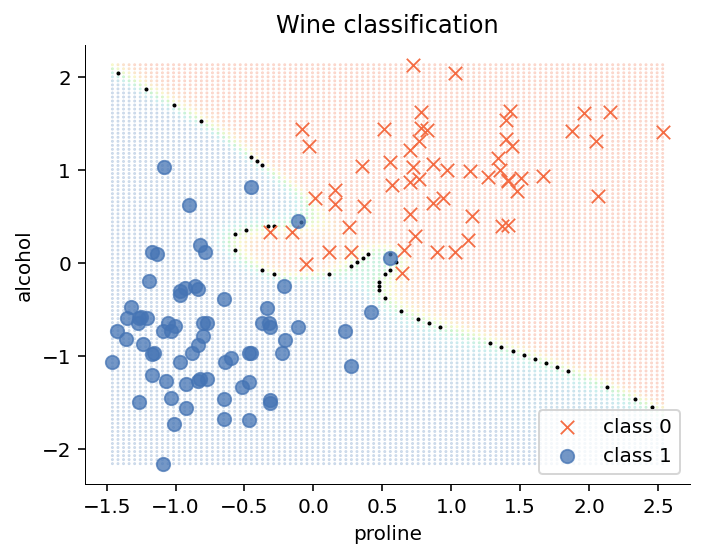

In [18]:
model = nn.Sequential(
    nn.Linear(2, 10), # 2 input vars: proline, alcohol, 10 neurons in hidden layer
    nn.Sigmoid(),
    nn.Linear(10, 1),
    nn.Sigmoid()
)
y_pred, loss = ctrain(model, X=X_, y=y_, learning_rate = .001, nepochs=15_000)

dshow(X, y, model, file="lin10Slin")

#### Exercise

Add another hidden layer with 10 neurons to the previous model and use ReLU not sigmoids for the activation of the hidden layers (but not for the final activation). See how that affects the boundary layer. You might have to run it multiple times as it can change depending on the random initializations of parameters. Try `learning_rate = .001` and a few other learning rates. I also notice that I only need about 5000 epochs, not 15,000 to drive the training loss very low.

<details>
<summary>Solution</summary>
    
<pre>
model = nn.Sequential(
    nn.Linear(2, 10), # 2 input vars: proline, alcohol
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid()
)

y_pred, loss = ctrain(model, X=X_, y=y_, learning_rate = .001, nepochs=5_000)
dshow(X, y, model, file="lin2Rlin10Rlin")
</pre>
</details>